# **MODEL**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import urllib.request

In [ ]:
# url = "https://drive.google.com/file/d/1Z-1ikFNBEDcGcgcUd1RkSonEB5mLCChQ/view?usp=sharing"
# filename = "ngirit_datasetnew.csv"
# urllib.request.urlretrieve(url, filename)

!gdown -- 1RZmZ0UaQzzxJZtmTpy3tg_rKBG0CDVRo

Downloading...
From: https://drive.google.com/uc?id=1RZmZ0UaQzzxJZtmTpy3tg_rKBG0CDVRo
To: /content/ngirit_datasetnew.csv
100% 1.16M/1.16M [00:00<00:00, 88.4MB/s]


In [ ]:
# Load and preprocess your dataset
data = pd.read_csv('ngirit_datasetnew.csv')

In [ ]:
data = data.drop('merchant_area',axis=1).replace(to_replace = 'NAN', value=np.NaN)
data['rating'] = pd.to_numeric(data['rating'])
data['rating'].fillna(float(data['rating'].mean()),inplace=True)

In [ ]:
category = np.array(data['sub_category'].value_counts().index)
unique_category = []
for kat in category:
  split = kat.split("/")
  for spl in split:
    if spl not in unique_category:
      unique_category.append(spl)

In [ ]:
unique_category

['jajanan',
 'minuman',
 'cepat_saji',
 'roti',
 'kopi',
 'sweets',
 'jepang',
 'barat',
 'aneka_nasi',
 'korea',
 'martabak',
 'ayam__bebek',
 'pizza_dan_pasta',
 'bakmie',
 'timur_tengah',
 'bakso__soto',
 'chinese',
 'seafood',
 'sate']

In [ ]:
data.head

<bound method NDFrame.head of            merchant_name  latitude   longitude  rating main_category  \
0      330 Kopi, Ciledug -6.238121  106.716895     3.6       Makanan   
1      330 Kopi, Ciledug -6.238121  106.716895     3.6       Makanan   
2      330 Kopi, Ciledug -6.238121  106.716895     3.6       Makanan   
3      330 Kopi, Ciledug -6.238121  106.716895     3.6       Makanan   
4      330 Kopi, Ciledug -6.238121  106.716895     3.6       Makanan   
...                  ...       ...         ...     ...           ...   
10953      XXI Cafe, PGC -6.262136  106.865563     4.2       Minuman   
10954      XXI Cafe, PGC -6.262136  106.865563     4.2       Minuman   
10955      XXI Cafe, PGC -6.262136  106.865563     4.2       Minuman   
10956      XXI Cafe, PGC -6.262136  106.865563     4.2       Minuman   
10957      XXI Cafe, PGC -6.262136  106.865563     4.2       Minuman   

      sub_category                     product    price  
0          jajanan         Pisang Lumer Coklat 

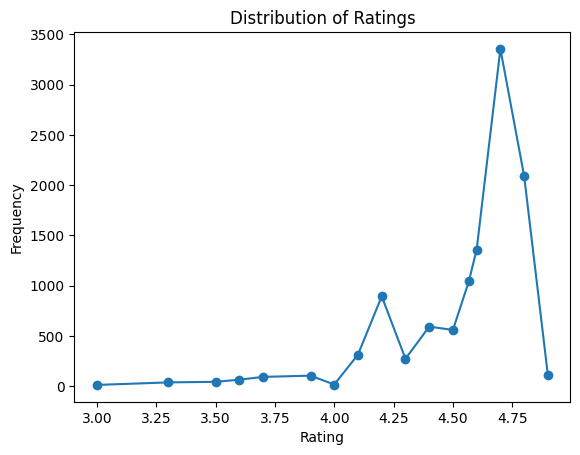

In [ ]:
# Ambil data rating dari dataset
ratings = data['rating']

# Hitung frekuensi masing-masing rating
rating_counts = ratings.value_counts().sort_index()

# Buat grafik titik garis
plt.plot(rating_counts.index, rating_counts.values, marker='o', linestyle='-')

# Atur label dan judul
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')

# Tampilkan grafik
plt.show()

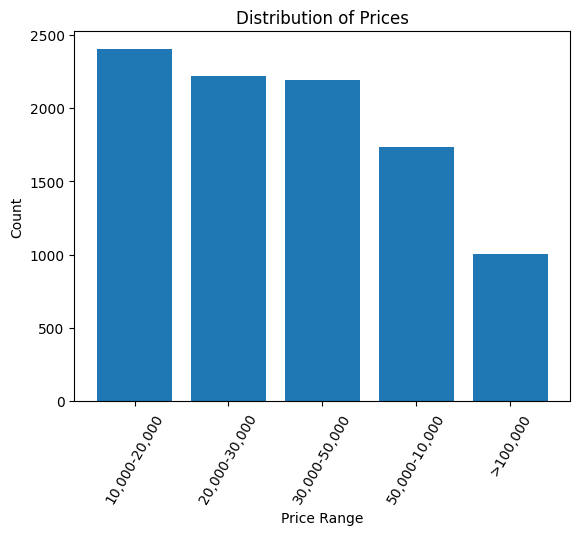

In [ ]:
# Menentukan rentang harga
price_ranges = ['10,000-20,000', '20,000-30,000', '30,000-50,000', '50,000-10,000', '>100,000']

# Mengelompokkan data berdasarkan rentang harga
data['price_range'] = pd.cut(data['price'], bins=[10000, 20000, 30000, 50000, 100000, float('inf')], labels=price_ranges)

# Menghitung jumlah entri dalam setiap rentang harga
price_counts = data['price_range'].value_counts().sort_index()

# Membuat grafik batang
plt.bar(price_counts.index, price_counts.values)

# Mengatur label dan judul
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.title('Distribution of Prices')

# Atur rotasi label jika diperlukan
plt.xticks(rotation=60)

# Menampilkan grafik
plt.show()

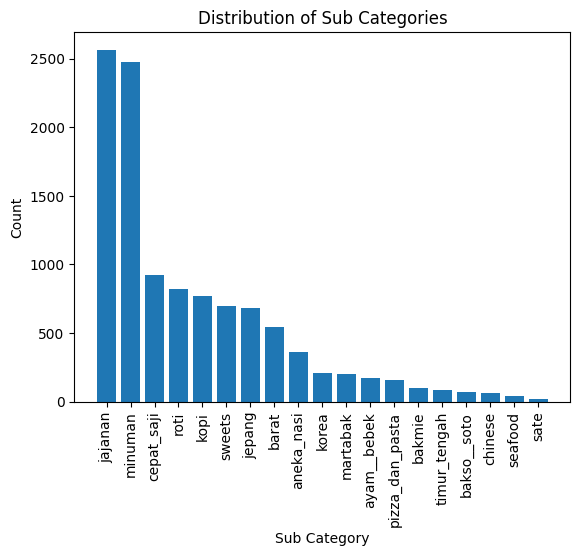

In [ ]:
# Ambil data sub kategori dari dataset
sub_categories = data['sub_category']

# Hitung jumlah kemunculan setiap sub kategori
sub_category_counts = sub_categories.value_counts()

# Buat grafik batang
plt.bar(sub_category_counts.index, sub_category_counts.values)

# Atur label dan judul
plt.xlabel('Sub Category')
plt.ylabel('Count')
plt.title('Distribution of Sub Categories')

# Atur rotasi label jika diperlukan
plt.xticks(rotation=90)

# Tampilkan grafik
plt.show()

In [ ]:
# Encode the target variable
label_encoder = LabelEncoder()
data['sub_category_encoded'] = label_encoder.fit_transform(data['sub_category'])

In [ ]:
# Menggabungkan kolom yang relevan untuk membuat teks yang akan digunakan untuk perhitungan kesamaan kosinus
data['combined_features'] = data[['merchant_name', 'main_category', 'sub_category', 'product']].apply(lambda x: ' '.join(x), axis=1)

In [ ]:
# Membuat matriks kecocokan kata kunci menggunakan CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(data['combined_features'])

In [ ]:
# Split the dataset into train and test sets
y = data['sub_category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Convert the sparse matrix to a dense matrix
X_train = X_train.toarray()
X_test = X_test.toarray()

In [ ]:
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

In [ ]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1),
                          input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
])

In [ ]:
# Adjust the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# Compile the Model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model with early stopping callback
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
274/274 [==============================] - 4s 11ms/step - loss: 2.7614 - accuracy: 0.6522 - val_loss: 0.9760 - val_accuracy: 0.9005
Epoch 2/100
274/274 [==============================] - 3s 9ms/step - loss: 0.9949 - accuracy: 0.8800 - val_loss: 0.7801 - val_accuracy: 0.9151
Epoch 3/100
274/274 [==============================] - 3s 9ms/step - loss: 0.8696 - accuracy: 0.9035 - val_loss: 0.7083 - val_accuracy: 0.9380
Epoch 4/100
274/274 [==============================] - 4s 13ms/step - loss: 0.8031 - accuracy: 0.9220 - val_loss: 0.6702 - val_accuracy: 0.9635
Epoch 5/100
274/274 [==============================] - 2s 9ms/step - loss: 0.7468 - accuracy: 0.9362 - val_loss: 0.6232 - val_accuracy: 0.9690
Epoch 6/100
274/274 [==============================] - 3s 9ms/step - loss: 0.7082 - accuracy: 0.9449 - val_loss: 0.5964 - val_accuracy: 0.9694
Epoch 7/100
274/274 [==============================] - 3s 9ms/step - loss: 0.6863 - accuracy: 0.9471 - val_loss: 0.5668 - val_accuracy: 0.97

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)

69/69 [==============================] - 0s 4ms/step - loss: 0.3460 - accuracy: 0.9950
Accuracy: 0.9949817657470703


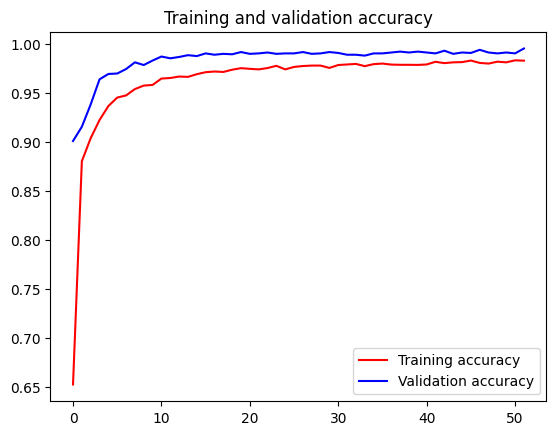

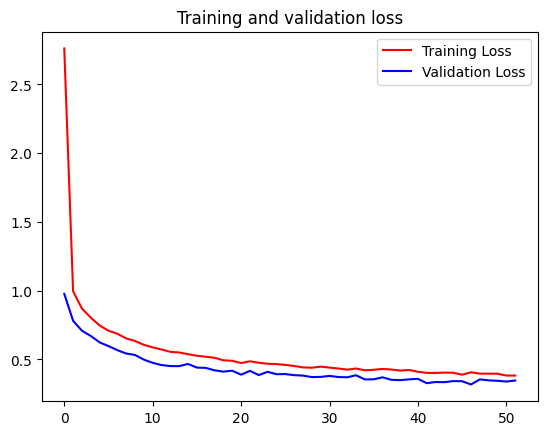

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **TESTING**

In [ ]:
# Define a function to predict and recommend products based on price and subcategory
def predict_and_recommend_products(price, sub_category, data):
    # Create a dataframe with the input data
    input_data = pd.DataFrame({'price': [price], 'sub_category': [sub_category]})
    
    # Preprocess the input data
    input_data['rating'] = data['rating'].mean()  # Set the rating as the average rating in the dataset
    input_data['sub_category_encoded'] = label_encoder.transform(input_data['sub_category'])
    input_data['combined_features'] = input_data[['sub_category']].apply(lambda x: ' '.join(x), axis=1)
    
    # Transform the input data using the CountVectorizer
    input_features = cv.transform(input_data['combined_features']).toarray()
    
    # Make predictions using the trained model
    predictions = model.predict(input_features)
    
    # Get the predicted class label
    predicted_class = np.argmax(predictions)
    
    # Filter the data based on the predicted class label and price range
    filtered_data = data[(data['sub_category_encoded'] == predicted_class) & (data['price'] <= price)]
    
    # Sort the filtered data based on rating in descending order
    sorted_data = filtered_data.sort_values(by='rating', ascending=False)
    
    # Select the top 10 recommended products
    recommended_products = sorted_data[['product', 'merchant_name', 'price', 'rating']].head(10)
    
    return recommended_products

In [ ]:
# Test the model with input price and sub category
price = 100000
sub_category = 'ayam__bebek'
recommended_products = predict_and_recommend_products(price, sub_category, data)

# Print the recommended products with merchant, price, and rating
print('Recommended Products:')
for i, row in recommended_products.iterrows():
    product = row['product']
    merchant_name = row['merchant_name']
    price = row['price']
    rating = row['rating']
    print(f'{i + 1}. Product: {product}')
    print(f'   Merchant: {merchant_name}')
    print(f'   Price: {price}')
    print(f'   Rating: {rating}\n')

1/1 [==============================] - 0s 53ms/step
Recommended Products:
6742. Product: Lalap
   Merchant: Restoran, Telaga Sindur
   Price: 5000.0
   Rating: 4.8

6730. Product: Tumis Kangkung
   Merchant: Restoran, Telaga Sindur
   Price: 18000.0
   Rating: 4.8

6719. Product: Gurame Goreng Terbang
   Merchant: Restoran, Telaga Sindur
   Price: 100000.0
   Rating: 4.8

6722. Product: Sop Gurame
   Merchant: Restoran, Telaga Sindur
   Price: 100000.0
   Rating: 4.8

6723. Product: Sop Patin
   Merchant: Restoran, Telaga Sindur
   Price: 78000.0
   Rating: 4.8

6724. Product: Patin Bakar
   Merchant: Restoran, Telaga Sindur
   Price: 75000.0
   Rating: 4.8

6725. Product: Ayam Taliwang TS
   Merchant: Restoran, Telaga Sindur
   Price: 80000.0
   Rating: 4.8

6718. Product: Gurame Bakar
   Merchant: Restoran, Telaga Sindur
   Price: 100000.0
   Rating: 4.8

6717. Product: Menu TS Satu
   Merchant: Restoran, Telaga Sindur
   Price: 40000.0
   Rating: 4.8

6727. Product: Ayam Goreng TS
 